In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random

# Установка random seed для воспроизводимости
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [2]:
# Загрузка и подготовка данных
df = pd.read_csv('df_cleaned_rdkit_morgan.csv')
df_filtered = df[df['IC50_nM'] > 0].copy()  # фильтрация, чтобы избежать log(0)
X = df_filtered.drop(columns=['canonical_smiles', 'IC50_nM'])
y = -np.log10(df_filtered['IC50_nM'])  # pIC50

# Делим на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [3]:
# Масштабируем признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# Классические модели
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)
mlp = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)

# Обучаем классические модели
rf.fit(X_train_scaled, y_train)
gb.fit(X_train_scaled, y_train)
mlp.fit(X_train_scaled, y_train)

rf_pred = rf.predict(X_test_scaled)
gb_pred = gb.predict(X_test_scaled)
mlp_pred = mlp.predict(X_test_scaled)

In [5]:
# CNN-модель на PyTorch
class SimpleCNN(nn.Module):
    def __init__(self, input_len):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(32 * ((input_len - 5 + 1) // 2), 64)
        self.out = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.out(x)

In [6]:
# Подготовка данных для PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = SimpleCNN(X_train_tensor.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [7]:
# Обучение CNN с записью loss для графика
epochs = 30
loss_history = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_loader.dataset)
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")

Epoch 1/30 - Loss: 1.8967
Epoch 2/30 - Loss: 1.0378
Epoch 3/30 - Loss: 0.9607
Epoch 4/30 - Loss: 0.8741
Epoch 5/30 - Loss: 0.8392
Epoch 6/30 - Loss: 0.8107
Epoch 7/30 - Loss: 0.7355
Epoch 8/30 - Loss: 0.7228
Epoch 9/30 - Loss: 0.6840
Epoch 10/30 - Loss: 0.6467
Epoch 11/30 - Loss: 0.6479
Epoch 12/30 - Loss: 0.6137
Epoch 13/30 - Loss: 0.5964
Epoch 14/30 - Loss: 0.5858
Epoch 15/30 - Loss: 0.5692
Epoch 16/30 - Loss: 0.5473
Epoch 17/30 - Loss: 0.5380
Epoch 18/30 - Loss: 0.5071
Epoch 19/30 - Loss: 0.4928
Epoch 20/30 - Loss: 0.4831
Epoch 21/30 - Loss: 0.4548
Epoch 22/30 - Loss: 0.4284
Epoch 23/30 - Loss: 0.4219
Epoch 24/30 - Loss: 0.3907
Epoch 25/30 - Loss: 0.3865
Epoch 26/30 - Loss: 0.3756
Epoch 27/30 - Loss: 0.3669
Epoch 28/30 - Loss: 0.3548
Epoch 29/30 - Loss: 0.3465
Epoch 30/30 - Loss: 0.3327


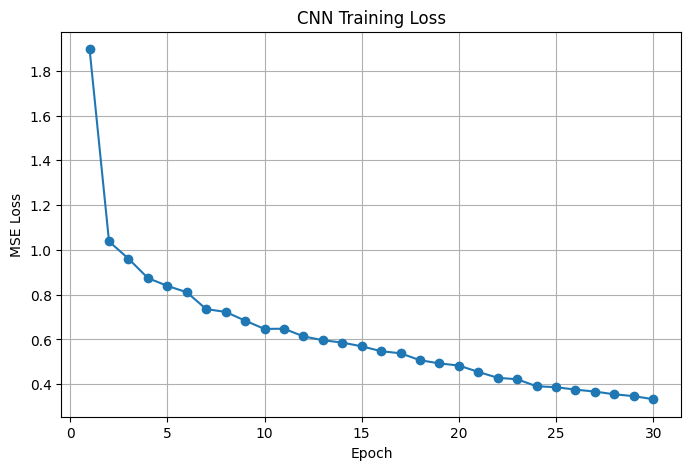

In [8]:
# Визуализация loss
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), loss_history, marker='o')
plt.title('CNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

In [9]:
# Предсказания CNN
model.eval()
with torch.no_grad():
    cnn_pred = model(X_test_tensor).squeeze().numpy()

In [10]:
# Функция оценки моделей
def evaluate(y_true, y_pred):
    return {
        'RMSE': root_mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

In [11]:
# Оценка всех моделей
results = {
    'RandomForest': evaluate(y_test, rf_pred),
    'GradientBoosting': evaluate(y_test, gb_pred),
    'MLP': evaluate(y_test, mlp_pred),
    'CNN': evaluate(y_test, cnn_pred)
}

results_df = pd.DataFrame(results).T
print(results_df)

                      RMSE       MAE        R2
RandomForest      0.769188  0.652580  0.577185
GradientBoosting  1.072965  0.830820  0.410201
MLP               0.922655  0.701170  0.492826
CNN               1.124843  0.761529  0.381684


In [12]:
# Кросс-валидация для RandomForest (оценка стабильности)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse = -cross_val_score(rf, scaler.fit_transform(X), y, scoring='neg_root_mean_squared_error', cv=kf)
print(f"\nRandomForest 5-fold CV RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")


RandomForest 5-fold CV RMSE: 0.8692 ± 0.0406


In [13]:
import joblib

# Сохраняем модель в файл
joblib.dump(rf, 'rf_model.pkl')


['rf_model.pkl']